# Brief Overview:
Project ⚛  Multiclass Multilabel prediction For stack overflow Questions<br>
**TASK**: Given text for Questions , predict tags associated with them <br>
Dataset ▶ <br>
Question.csv<br>
answer.csv <br>tag.csv<br>
▶**Multi-class-Multi-label classification**: In deep learning, a multi-class multi-label prediction problem is one where each sample/observation in the dataset can belong to multiple classes simultaneously. This contrasts with a simple multi-class prediction problem, where each sample belongs to exactly one of several possible classes. <br>
**Sigmoid Activation** is used for output. The sigmoid function is used in multi-label classification because it outputs probabilities between 0 and 1 for each class independently. This allows each class to be predicted independently, fitting the scenario where a sample can belong to multiple classes at the same time.

# Importing libraries and loading data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense,Embedding,Dropout,BatchNormalization,Input
from tensorflow.keras.models import Model

In [ ]:
!wget -q show-progress https://www.dropbox.com/s/5721wcs2guuykzl/stacksample.zip?dl=0

In [ ]:
!unzip /content/stacksample.zip?dl=0

Archive:  /content/stacksample.zip?dl=0
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


In [ ]:
question_df = pd.read_csv('/content/Questions.csv', encoding='latin-1')
tags_df  = pd.read_csv('/content/Tags.csv', encoding='latin-1')

In [ ]:
question_df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [ ]:
question_df.Body[0]

'<p>I\'ve written a database generation script in <a href="http://en.wikipedia.org/wiki/SQL">SQL</a> and want to execute it in my <a href="http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table tRole (\n      roleID integer Primary Key\n      ,roleName varchar(40)\n);\nCreate Table tFile (\n    fileID integer Primary Key\n    ,fileName varchar(50)\n    ,fileDescription varchar(500)\n    ,thumbnailID integer\n    ,fileFormatID integer\n    ,categoryID integer\n    ,isFavorite boolean\n    ,dateAdded date\n    ,globalAccessCount integer\n    ,lastAccessTime date\n    ,downloadComplete boolean\n    ,isNew boolean\n    ,isSpotlight boolean\n    ,duration varchar(30)\n);\nCreate Table tCategory (\n    categoryID integer Primary Key\n    ,categoryName varchar(50)\n    ,parent_categoryID integer\n);\n...\n</code></pre>\n\n<p>I execute this in Adobe AIR using the following methods:</p>\n\n<pre><code>public static function RunSqlFromFile

In [ ]:
question_df.Body[500]

'<p>What\'s the best way to implement a SQL script that will grant select, references, insert, update, and delete permissions to a database role on all the user tables in a database?</p>\n\n<p>Ideally, this script could be run multiple times, as new tables were added to the database. SQL Server Management Studio generates scripts for individual database objects, but I\'m looking for more of a "fire-and-forget" script.</p>\n'

In [ ]:
tags_df.head(10)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
5,90,branch
6,90,branching-and-merging
7,120,sql
8,120,asp.net
9,120,sitemap


In [ ]:
print(f'shape of question_df {question_df.shape}')

print(f'shape of tags_df {tags_df.shape}')

shape of question_df (1264216, 7)
shape of tags_df (3750994, 2)


In [ ]:
question_df.isna().sum()

,0
Id,0
OwnerUserId,14454
CreationDate,0
ClosedDate,1208257
Score,0
Title,0
Body,0


In [ ]:
question_df.drop(columns=['OwnerUserId','CreationDate','ClosedDate','Score'],axis=1,inplace=True)
question_df.columns

Index(['Id', 'Title', 'Body'], dtype='object')

In [ ]:
question_df['text'] = question_df['Title']+' '+question_df['Body']
question_df.head(2)

,Id,Title,Body,text
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,SQLStatement.execute() - multiple queries in o...
1,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,Good branching and merging tutorials for Torto...


In [ ]:
question_df.text[0]

'SQLStatement.execute() - multiple queries in one statement <p>I\'ve written a database generation script in <a href="http://en.wikipedia.org/wiki/SQL">SQL</a> and want to execute it in my <a href="http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table tRole (\n      roleID integer Primary Key\n      ,roleName varchar(40)\n);\nCreate Table tFile (\n    fileID integer Primary Key\n    ,fileName varchar(50)\n    ,fileDescription varchar(500)\n    ,thumbnailID integer\n    ,fileFormatID integer\n    ,categoryID integer\n    ,isFavorite boolean\n    ,dateAdded date\n    ,globalAccessCount integer\n    ,lastAccessTime date\n    ,downloadComplete boolean\n    ,isNew boolean\n    ,isSpotlight boolean\n    ,duration varchar(30)\n);\nCreate Table tCategory (\n    categoryID integer Primary Key\n    ,categoryName varchar(50)\n    ,parent_categoryID integer\n);\n...\n</code></pre>\n\n<p>I execute this in Adobe AIR using the following metho

In [ ]:
question_df.drop(columns=['Title','Body'], axis=1, inplace=True)
question_df.columns

Index(['Id', 'text'], dtype='object')

In [ ]:
tags_df.isna().sum()

,0
Id,0
Tag,1113


In [ ]:
p = (tags_df['Tag'].isna().sum())*100 / tags_df.shape[0]
print('Percentage of Missing value - ', p)

Percentage of Missing value -  0.029672134906107553


since the % of missing values is too small either we can impute it or drop it

In [ ]:
target_df = tags_df.dropna(axis=0, how='any', inplace=False)
target_df.isna().sum()

,0
Id,0
Tag,0


In [ ]:
print(f'shape of target data {target_df.shape}')
print(f'shape of question data {question_df.shape}')

shape of target data (3749881, 2)
shape of question data (1264216, 2)


# Joining all the tags associated with same ID.
--- by grouping in the target dataframe.
 one id having multiple labels/tags. Doing this to get all the tag name associated with one ID which will be utilised to get the top tag counts for filtering. It will be used for merging the data frames to get tag and text in one dataframe for training and prediction.

In [ ]:
df_grouped = target_df.groupby('Id')['Tag'].apply(lambda x: ','.join(x)).reset_index()
df_grouped.head()

,Id,Tag
0,80,"flex,actionscript-3,air"
1,90,"svn,tortoisesvn,branch,branching-and-merging"
2,120,"sql,asp.net,sitemap"
3,180,"algorithm,language-agnostic,colors,color-space"
4,260,"c#,.net,scripting,compiler-construction"


In [ ]:
df_grouped.shape

(1264214, 2)

In [ ]:
question_df.shape  # both are having same unique Id hence same number of rows

(1264216, 2)

In [ ]:
question_df.duplicated().sum()

0

In [ ]:
df_grouped.Tag.nunique()  # number of all unique tags after grouping them by id

685263

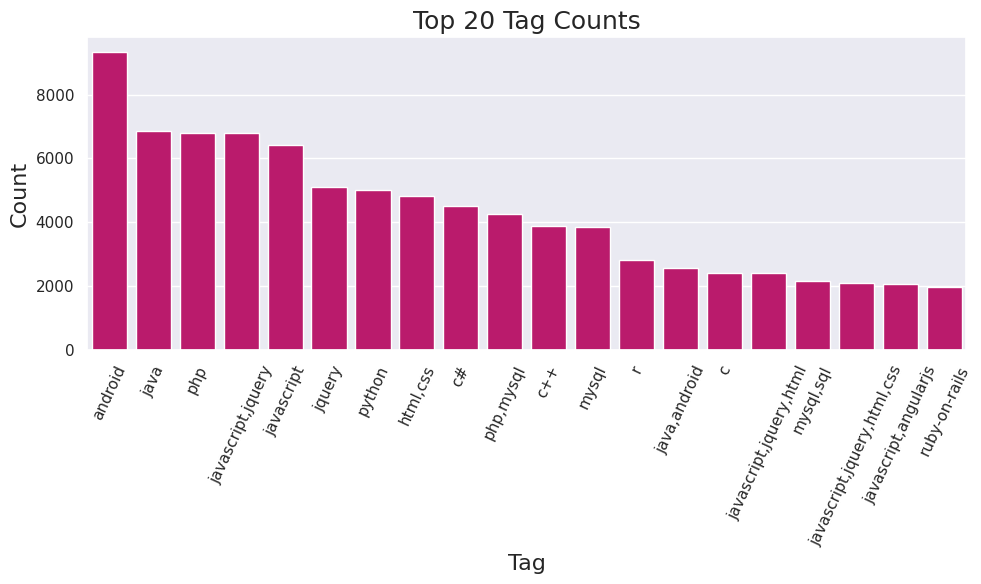

In [ ]:
tags_counts = df_grouped.Tag.value_counts().head(20).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.set(style='darkgrid')
sns.barplot(x=tags_counts.index, y=tags_counts.values, color='#D5006D')
plt.title('Top 20 Tag Counts', fontsize=18)
plt.xticks(rotation=65)
plt.xlabel('Tag', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.tight_layout()
plt.show();

# Merging why?
 merging question_df with the df_grouped to get all the tags and the body(content to predict) together

In [ ]:
merged_df = pd.merge(question_df, df_grouped, on='Id', how='inner')
merged_df.head()

,Id,text,Tag
0,80,SQLStatement.execute() - multiple queries in o...,"flex,actionscript-3,air"
1,90,Good branching and merging tutorials for Torto...,"svn,tortoisesvn,branch,branching-and-merging"
2,120,ASP.NET Site Maps <p>Has anyone got experience...,"sql,asp.net,sitemap"
3,180,Function for creating color wheels <p>This is ...,"algorithm,language-agnostic,colors,color-space"
4,260,Adding scripting functionality to .NET applica...,"c#,.net,scripting,compiler-construction"


In [ ]:
top_tags = tags_counts.index
top_tags

Index(['android', 'java', 'php', 'javascript,jquery', 'javascript', 'jquery',
       'python', 'html,css', 'c#', 'php,mysql', 'c++', 'mysql', 'r',
       'java,android', 'c', 'javascript,jquery,html', 'mysql,sql',
       'javascript,jquery,html,css', 'javascript,angularjs', 'ruby-on-rails'],
      dtype='object', name='Tag')

# Sorting/Filtering the data frame
 - To Pick top 20 most occurring tags and filter data for them and build model for them.


In [ ]:
new_df = merged_df[merged_df['Tag'].isin(top_tags)]
new_df.head()

,Id,text,Tag
34,2900,MySQL/Apache Error in PHP MySQL query <p>I am ...,"php,mysql"
135,13000,How to setup site-wide variables in php? <p>I ...,php
192,17870,Select ..... where .... OR <p>Is there a way ...,mysql
195,17980,What Comes After The %? <p>I've searched for t...,c
205,19280,Code to ask yes/no question in javascript <p>I...,javascript


In [ ]:
new_df.shape

(86236, 3)

In [ ]:
# Split the tags (comma-separated) into lists so that Multlabelbinarizer can be applied
target = new_df['Tag'].apply(lambda x: x.split(','))
target.head()

,Tag
34,"[php, mysql]"
135,[php]
192,[mysql]
195,[c]
205,[javascript]


In [ ]:
target = target.to_frame()
target.Tag.value_counts().head(20).sort_values(ascending=False).index

Index([                            ['android'],
                                      ['java'],
                                       ['php'],
                      ['javascript', 'jquery'],
                                ['javascript'],
                                    ['jquery'],
                                    ['python'],
                               ['html', 'css'],
                                        ['c#'],
                              ['php', 'mysql'],
                                       ['c++'],
                                     ['mysql'],
                                         ['r'],
                           ['java', 'android'],
                                         ['c'],
              ['javascript', 'jquery', 'html'],
                              ['mysql', 'sql'],
       ['javascript', 'jquery', 'html', 'css'],
                   ['javascript', 'angularjs'],
                             ['ruby-on-rails']],
      dtype='object', name='Tag')

# using multilabelbinarizer to convert list of string into binary matrix

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(target['Tag'])
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y[0] # binary value of tag - php,mysql for id 2900 - above new_df

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [ ]:
y[1] # binary value of tag -php for id 13000

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
y.shape

(86236, 16)

In [ ]:
print(mlb.classes_) # 16

['android' 'angularjs' 'c' 'c#' 'c++' 'css' 'html' 'java' 'javascript'
 'jquery' 'mysql' 'php' 'python' 'r' 'ruby-on-rails' 'sql']


# Text preprocessing

In [ ]:
# Remove html tags
import re

from bs4 import BeautifulSoup

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Remove url

def remove_url(text):
  pattern = re.compile(r'https?://\S+|www\.\S+')
  return pattern.sub(r'', text)

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
!pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 11.3 MB/s eta 0:00:00


In [ ]:
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import contractions
import re

def transform_text(text):
    # Lowercase text
    text = text.lower()

    # Remove HTML tags and URLs
    text = remove_html_tags(text)
    text = remove_url(text)

    # Expand contractions
    text = contractions.fix(text)

    # Tokenize text into words
    text = word_tokenize(text)

    # Remove stopwords, non-alphanumeric words, and lemmatize
    lemmatizer = WordNetLemmatizer()
    text = [
        lemmatizer.lemmatize(word)
        for word in text
        if word not in ENGLISH_STOP_WORDS and word.isalnum()
    ]

    # Join cleaned words into a string
    return " ".join(text)


In [ ]:
X = new_df['text']
X = X.apply(transform_text)
X.head()

<ipython-input-36-f3ea62cf773b>:7: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(text, 'html.parser')


,text
34,error php mysql query getting following error ...
135,setup variable php want define like php el br ...
192,select way select data multiple condition occu...
195,come searched little gotten particularly strai...
205,code ask question javascript function confirm ...


# WordCloud to visualize frequency of word

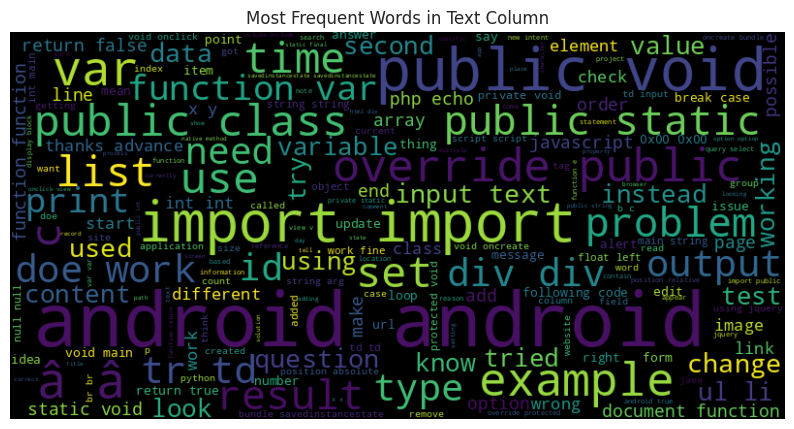

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(X.dropna())  # Combine all text into one string

# Generate the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='Black').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Most Frequent Words in Text Column')
plt.show()


# Splitting train-test and preprocessing for Sequence model



In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((68988,), (17248,), (68988, 16), (17248, 16))

In [ ]:
sen_lens = []
for sent in X:
  sen_lens.append(len(word_tokenize(sent)))

In [ ]:
sen_lens[:10]

[84, 36, 32, 35, 10, 41, 50, 33, 69, 12]

In [ ]:
min(sen_lens), max(sen_lens)

(0, 3035)

In [ ]:
np.quantile(sen_lens,0.95)

197.0

In [ ]:
seq_len = 197

In [ ]:
tok = Tokenizer(char_level=False, split=' ')
tok.fit_on_texts(X_train) # finds vocabulary/word and assigns int

In [ ]:
len(tok.index_word)

164526

In [ ]:
X_train.reset_index(drop=True, inplace=True)

In [ ]:
sequences_train = tok.texts_to_sequences(X_train)

In [ ]:
X_train[5]

'db field based conditional input 4 input field descrition hidden promo1 promo2 promo3 user promo field managed radio button promos field display according radio checked populate description data promo 1 2 3 based radio button checked'

In [ ]:
sequences_train[5]

[345,
 122,
 262,
 2043,
 21,
 62,
 21,
 122,
 91830,
 255,
 91831,
 91832,
 91833,
 27,
 10476,
 122,
 1559,
 343,
 30,
 11769,
 122,
 67,
 816,
 343,
 391,
 1346,
 415,
 22,
 10476,
 3,
 13,
 28,
 262,
 343,
 30,
 391]

In [ ]:
sequence_train_padded = sequence.pad_sequences(sequences_train, maxlen = seq_len)

In [ ]:
sequence_train_padded.shape

(68988, 197)

In [ ]:
sequences_test = tok.texts_to_sequences(X_test)

In [ ]:
sequence_test_padded = sequence.pad_sequences(sequences_test,
                                              maxlen= seq_len)

# Architecture for RNN

In [ ]:
inputs = Input(shape=[seq_len], name='input')
embeded_layer = Embedding(input_dim= len(tok.index_word)+1, output_dim=200, mask_zero=True, name='embeded_layer')(inputs)

rnn_layer = SimpleRNN(units=64, name='rnn_layer')(embeded_layer)

dense1 = Dense(units=32, activation='relu', name='dense1')(rnn_layer)
batch1 = BatchNormalization(name='batch1')(dense1)
drop1 = Dropout(rate=0.25, name='drop1')(batch1)

dense2 = Dense(units=32, activation='relu', name='dense2')(drop1)
batch2 = BatchNormalization(name='batch2')(dense2)
drop2 = Dropout(rate=0.25, name='drop2')(batch2)

output = Dense(units=y.shape[1], activation='sigmoid', name='output')(drop2)

model = Model(inputs=inputs, outputs=output)


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 197)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embeded_layer (Embedding) │ (None, 197, 200)       │     32,905,400 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 197)            │              0 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rnn_layer (SimpleRNN)     │ (None, 64)             │         16,960 │ embeded_layer[0][0],   │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 32)             │          2,080 │ rnn_layer[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch1                    │ (None, 32)             │            128 │ dense1[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drop1 (Dropout)           │ (None, 32)             │              0 │ batch1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 32)             │          1,056 │ drop1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch2                    │ (None, 32)             │            128 │ dense2[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drop2 (Dropout)           │ (None, 32)             │              0 │ batch2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 16)             │            528 │ drop2[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,926,280 (125.60 MB)

 Trainable params: 32,926,152 (125.60 MB)

 Non-trainable params: 128 (512.00 B)

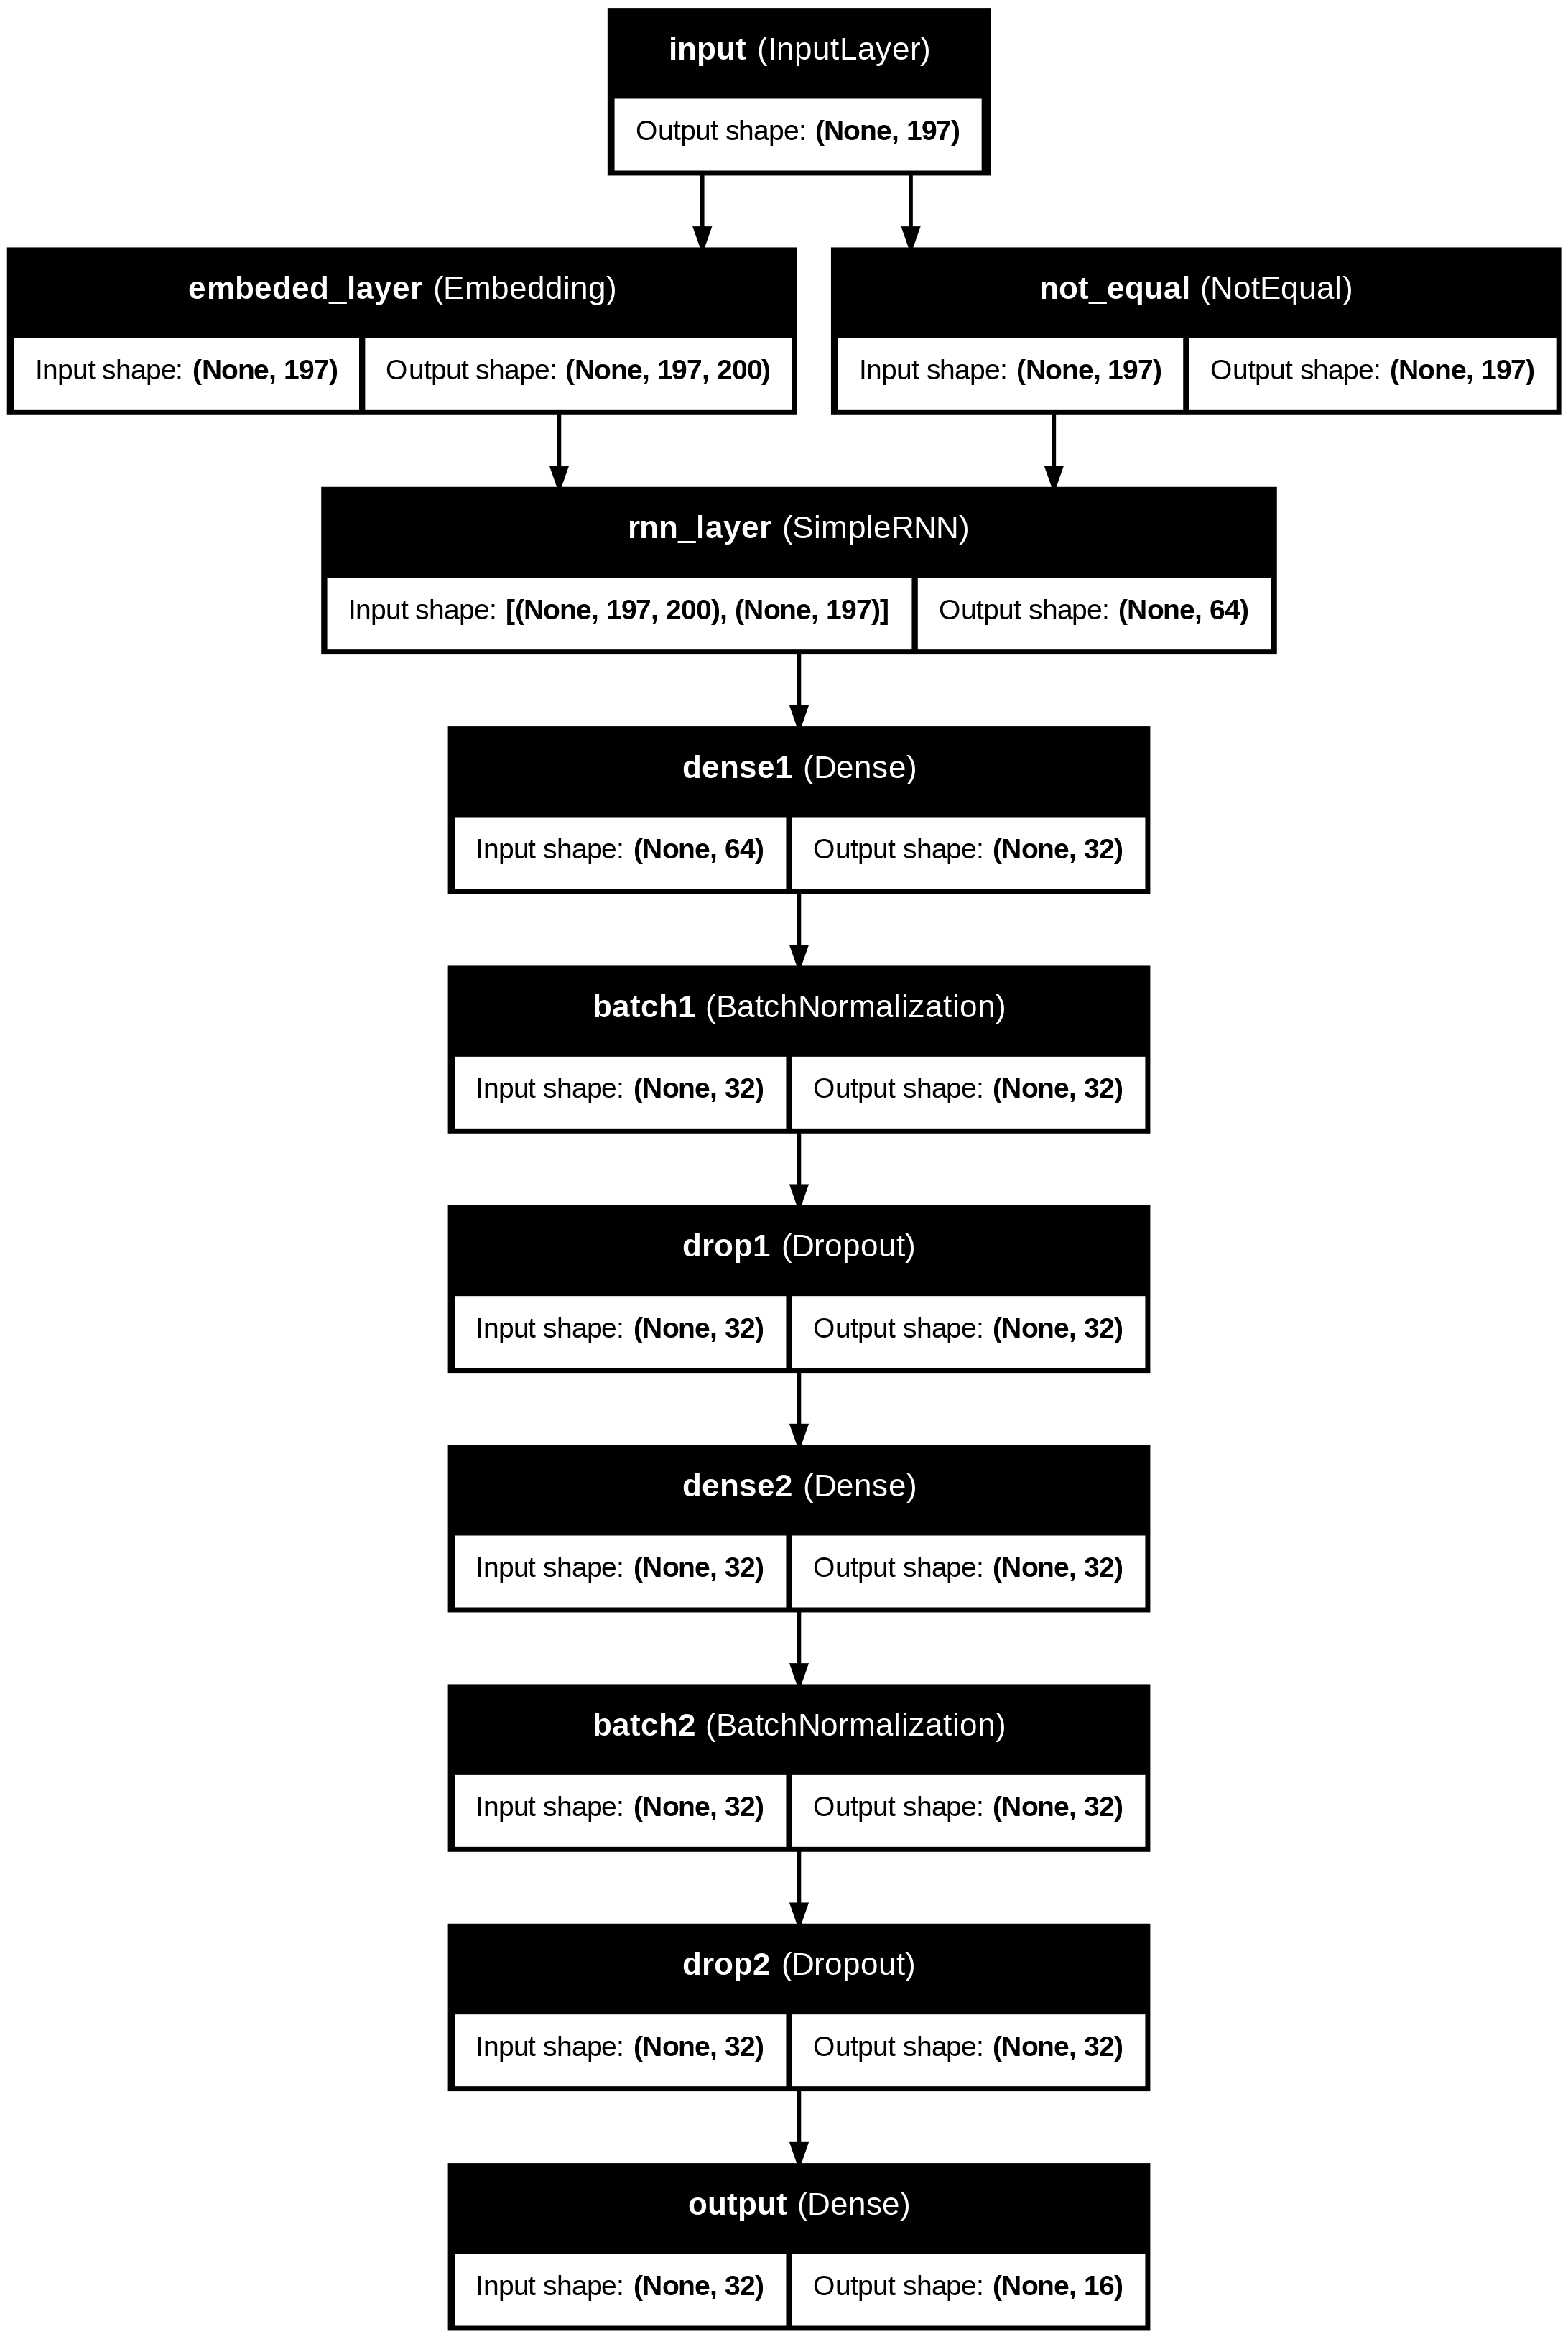

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',       # Use .keras format instead of .h5
    monitor='val_accuracy',            # Metric to monitor
    save_best_only=True,               # Save only the model with the best val_accuracy
    mode='max',                        # Mode for monitoring (maximize val_accuracy)
    verbose=1                          # Display logs when the model is saved
)


In [ ]:
model.fit(sequence_train_padded, y_train, epochs=10, batch_size=500,
          validation_data=(sequence_test_padded, y_test), callbacks=[earlystop,checkpoint_callback])

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.0717 - loss: 0.7608
Epoch 1: val_accuracy improved from -inf to 0.06633, saving model to best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 120s 822ms/step - accuracy: 0.0717 - loss: 0.7602 - val_accuracy: 0.0663 - val_loss: 0.4969
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.1206 - loss: 0.4429
Epoch 2: val_accuracy improved from 0.06633 to 0.26235, saving model to best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 141s 814ms/step - accuracy: 0.1209 - loss: 0.4424 - val_accuracy: 0.2623 - val_loss: 0.2426
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.2285 - loss: 0.2616
Epoch 3: val_accuracy improved from 0.26235 to 0.30264, saving model to best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 153s 892ms/step - accuracy: 0.2285 - loss: 0.2615 - val_accuracy: 0.3026 - val_loss: 0.2166
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.2708 - loss: 0.2287
Epoch 4: val_accuracy

# Architecture for LSTM

In [ ]:
inputs = Input(shape=[seq_len])
embeded_layer = Embedding(input_dim= len(tok.index_word)+1, output_dim=200)(inputs)
b = BatchNormalization()(embeded_layer)

lstm_layer = LSTM(units=128)(b)

dense1 = Dense(units=1024, activation='relu')(lstm_layer)
batch1 = BatchNormalization()(dense1)
drop1 = Dropout(rate=0.25)(batch1)

dense2 = Dense(units=128, activation='relu')(drop1)
batch2 = BatchNormalization()(dense2)
drop2 = Dropout(rate=0.25)(batch2)

output = Dense(units=y.shape[1], activation='sigmoid')(drop2)

lstm_model = Model(inputs=inputs, outputs=output)


In [ ]:
# Compile LSTM model with accuracy and ROC-AUC as metrics
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])

In [ ]:
# For LSTM model
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback_lstm = ModelCheckpoint(
    filepath='lstm_best_model.keras',  # Save LSTM model with a unique name
    monitor='val_accuracy',            # in order to avoid overwriting of the file
    save_best_only=True,
    mode='max',
    verbose=1
)


In [ ]:
lstm_model.fit(sequence_train_padded, y_train, epochs=20, batch_size=128,
          validation_data=(sequence_test_padded, y_test), callbacks=[earlystop,checkpoint_callback_lstm])

Epoch 1/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - AUC: 0.8089 - accuracy: 0.4044 - loss: 0.4387
Epoch 1: val_accuracy improved from -inf to 0.68089, saving model to lstm_best_model.keras
539/539 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - AUC: 0.8091 - accuracy: 0.4047 - loss: 0.4383 - val_AUC: 0.9837 - val_accuracy: 0.6809 - val_loss: 0.0882
Epoch 2/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.9885 - accuracy: 0.7466 - loss: 0.0688
Epoch 2: val_accuracy improved from 0.68089 to 0.73243, saving model to lstm_best_model.keras
539/539 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - AUC: 0.9885 - accuracy: 0.7466 - loss: 0.0688 - val_AUC: 0.9859 - val_accuracy: 0.7324 - val_loss: 0.0789
Epoch 3/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.9946 - accuracy: 0.7807 - loss: 0.0468
Epoch 3: val_accuracy did not improve from 0.73243
539/539 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - AUC: 0.9946 - accuracy: 0.7807 - loss: 0.0468 - val_AUC: 0.9800 - val_accuracy: 0.7081 - val_loss: 0.0821
Epoch 4/

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('/content/lstm_best_model.keras')


In [ ]:
predictions = best_model.predict(sequence_test_padded, batch_size=128, verbose=0)

In [ ]:
# Convert probabilities to binary labels (0 or 1) using a threshold
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)
print(binary_predictions[:10])

[[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
# Output the questions and corresponding predicted tags
for i, pred in enumerate(binary_predictions[:30]):  # Limiting to 30 for performance check
    question_text = X_test.iloc[i]
    predicted_tags = mlb.classes_[pred==1]
    print(f"Question: {question_text}")
    print(f"Predicted Tags: {predicted_tags}")
    print("-" * 50)


Question: doe print updated model data angular j table data view html click print need data db print getting data populating model data click print model updated print show old data code newitems added item click print html div div printctrl br div overallprint float left h4 overall report table 1 thead tr td td price td quantity tbody tr item item td td td br input button print overall j function printctrl scope window q soap price 25 quantity 10 shaving cream price 50 quantity 15 shampoo price 100 quantity 5 function 0
Predicted Tags: ['angularjs' 'javascript']
--------------------------------------------------
Question: jquery set focus autocomplete list element focus created autocomplete menu item ul 0 li presentation li presentation tried effect generaly mean custom autocomplete
Predicted Tags: ['javascript' 'jquery']
--------------------------------------------------
Question: error message come piece code intro code message question 1 error prohibited article saved title short m

539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


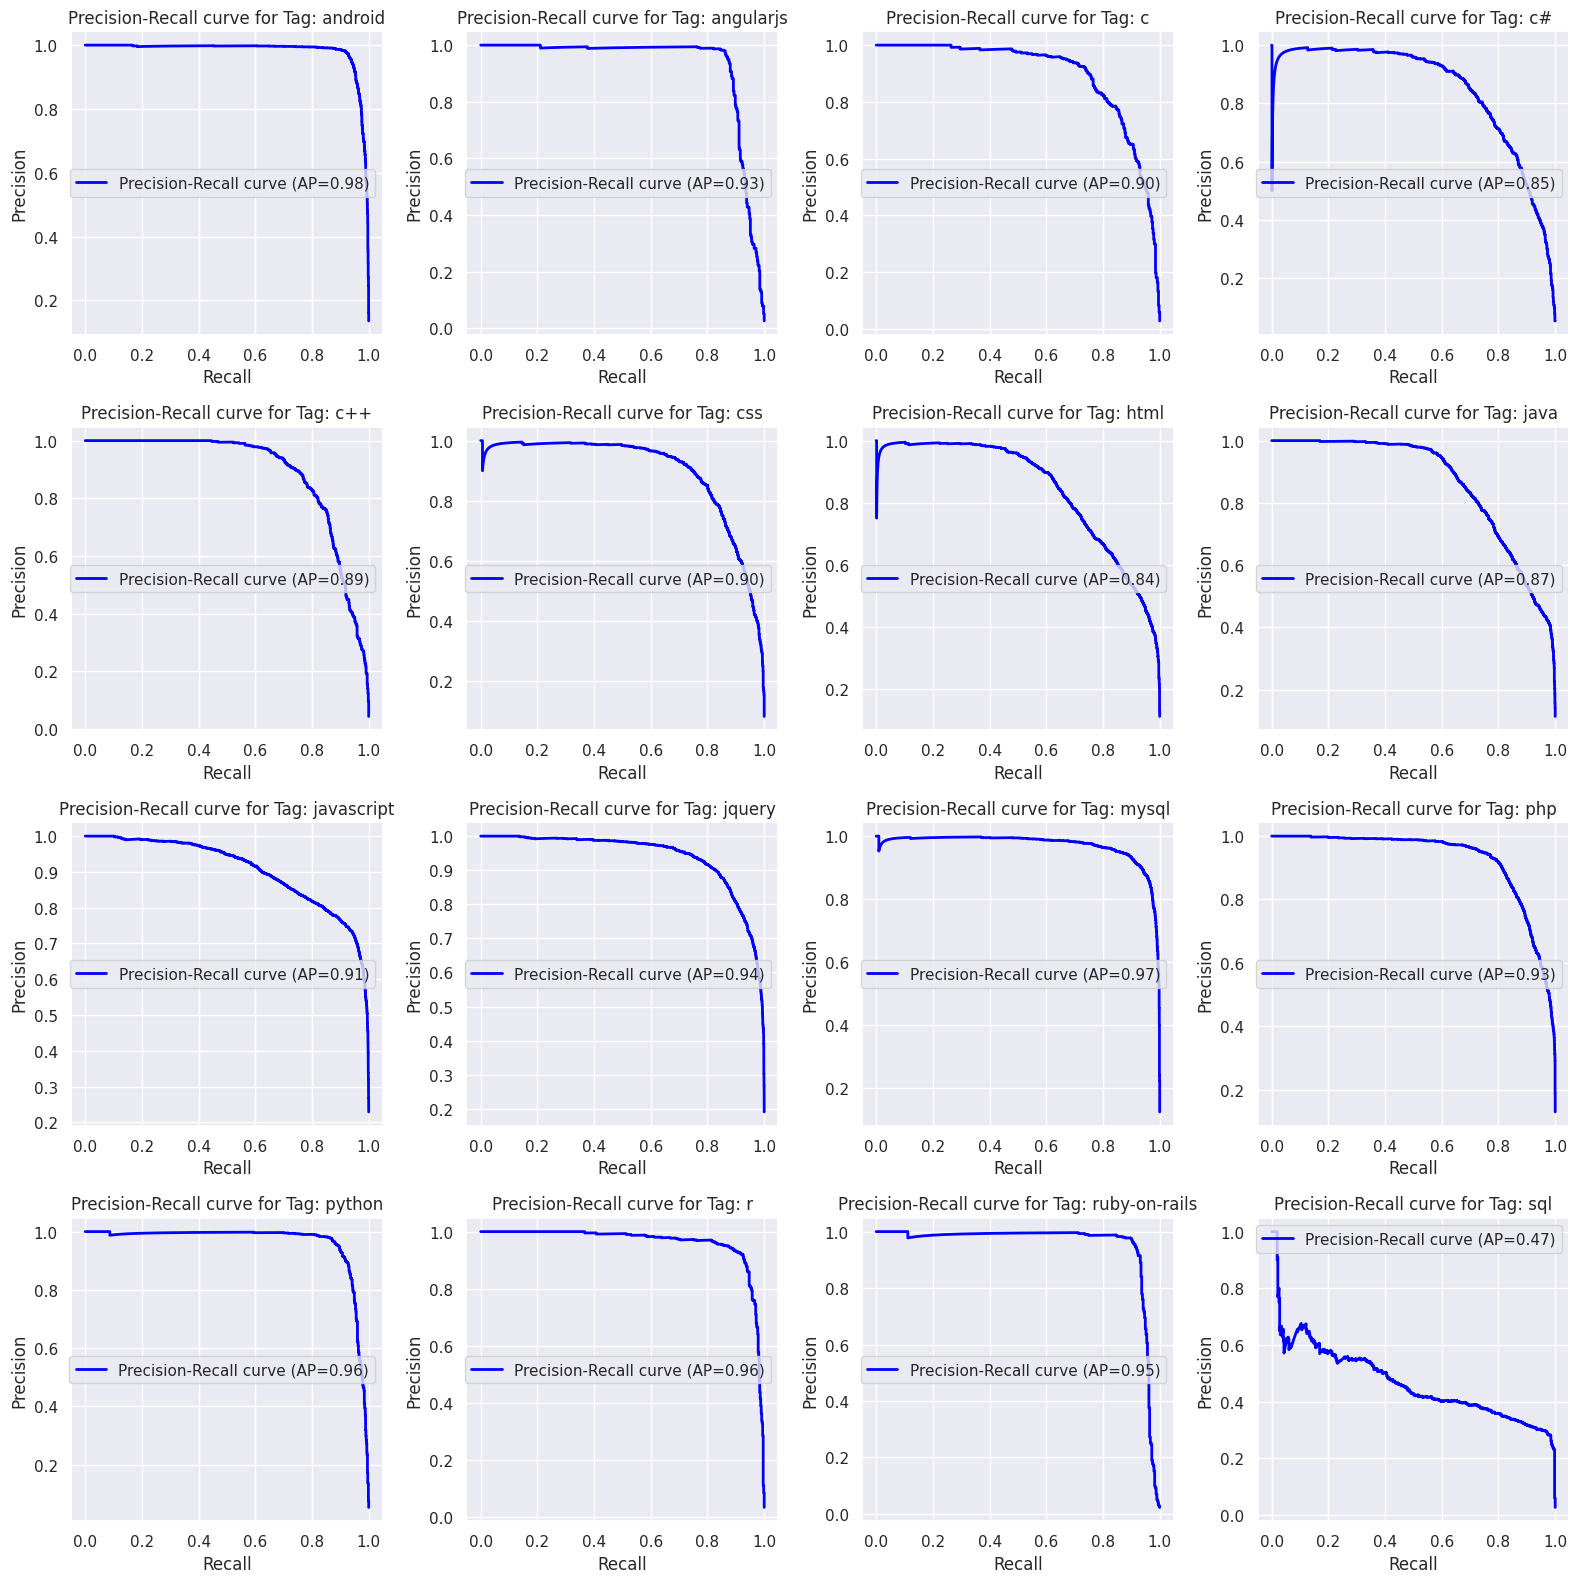

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_true =y_test # actual label
y_pred = best_model.predict(sequence_test_padded) # Predicted labels

# Number of tags (e.g., if there are 16 tags, this will work for a 4x4 grid)
num_tags = y_true.shape[1]

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten() # Flatten the 2D axes array to make indexing easier

# Loop over all tags and plot Precision-Recall curve for each
for i in range(num_tags):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision = average_precision_score(y_true[:, i], y_pred[:, i])

    ax = axes[i]
    ax.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP={average_precision:.2f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall curve for Tag: {mlb.classes_[i]}')
    ax.legend(loc='best')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Architecture for GRU

In [ ]:
inputs = Input(shape=[seq_len])
embeded_layer = Embedding(input_dim= len(tok.index_word)+1, output_dim=200)(inputs)
b = BatchNormalization()(embeded_layer)

gru_layer = GRU(units=256)(b)

dense1 = Dense(units=1024, activation='relu')(gru_layer)
batch1 = BatchNormalization()(dense1)
drop1 = Dropout(rate=0.25)(batch1)

dense2 = Dense(units=128, activation='relu')(drop1)
batch2 = BatchNormalization()(dense2)
drop2 = Dropout(rate=0.25)(batch2)

output = Dense(units=y.shape[1], activation='sigmoid')(drop2)

gru_model = Model(inputs=inputs, outputs=output)


In [ ]:
checkpoint_callback_gru = ModelCheckpoint(
    filepath='gru_best_model.keras',  # Save GRU model with a unique name
    monitor='val_accuracy',            # in order to avoid overwriting of the file
    save_best_only=True,
    mode='max',
    verbose=1
)


In [ ]:
gru_model.compile(optimizer= 'adam', loss='binary_crossentropy',metrics=['accuracy','AUC'] )

In [ ]:
# Model training
gru_model.fit(sequence_train_padded, y_train, epochs=20, batch_size=128,
              validation_data= (sequence_test_padded,y_test), callbacks=[earlystop,checkpoint_callback_gru])

Epoch 1/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - AUC: 0.7973 - accuracy: 0.3863 - loss: 0.4429
Epoch 1: val_accuracy improved from -inf to 0.60100, saving model to gru_best_model.keras
539/539 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - AUC: 0.7975 - accuracy: 0.3867 - loss: 0.4426 - val_AUC: 0.9365 - val_accuracy: 0.6010 - val_loss: 0.1471
Epoch 2/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - AUC: 0.9898 - accuracy: 0.7580 - loss: 0.0656
Epoch 2: val_accuracy improved from 0.60100 to 0.75771, saving model to gru_best_model.keras
539/539 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - AUC: 0.9898 - accuracy: 0.7580 - loss: 0.0656 - val_AUC: 0.9659 - val_accuracy: 0.7577 - val_loss: 0.1118
Epoch 3/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - AUC: 0.9956 - accuracy: 0.7913 - loss: 0.0428
Epoch 3: val_accuracy did not improve from 0.75771
539/539 ━━━━━━━━━━━━━━━━━━━━ 70s 57ms/step - AUC: 0.9956 - accuracy: 0.7913 - loss: 0.0428 - val_AUC: 0.9755 - val_accuracy: 0.7226 - val_loss: 0.0942
Epoch 4/20

In [ ]:
# Load the best model
best_model = load_model('/content/gru_best_model.keras')

In [ ]:
predictions = best_model.predict(sequence_test_padded, batch_size=128, verbose=0)

In [ ]:
# Convert probabilities to binary labels (0 or 1) using a threshold
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)
print(binary_predictions[:10])

[[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
df = pd.DataFrame(binary_predictions)
df.to_csv('Multiclass_multilabel_prediction.csv', index=False)

In [ ]:
# Output the questions and corresponding predicted tags
for i, pred in enumerate(binary_predictions[:20]):  # Limiting to 30 for performance check
    question_text = X_test.iloc[i]
    predicted_tags = mlb.classes_[pred==1]
    print(f"Question: {question_text}")
    print(f"Predicted Tags: {predicted_tags}")
    print("-" * 50)


Question: doe print updated model data angular j table data view html click print need data db print getting data populating model data click print model updated print show old data code newitems added item click print html div div printctrl br div overallprint float left h4 overall report table 1 thead tr td td price td quantity tbody tr item item td td td br input button print overall j function printctrl scope window q soap price 25 quantity 10 shaving cream price 50 quantity 15 shampoo price 100 quantity 5 function 0
Predicted Tags: ['angularjs' 'javascript']
--------------------------------------------------
Question: jquery set focus autocomplete list element focus created autocomplete menu item ul 0 li presentation li presentation tried effect generaly mean custom autocomplete
Predicted Tags: ['jquery']
--------------------------------------------------
Question: error message come piece code intro code message question 1 error prohibited article saved title short minimum 5 char

539/539 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


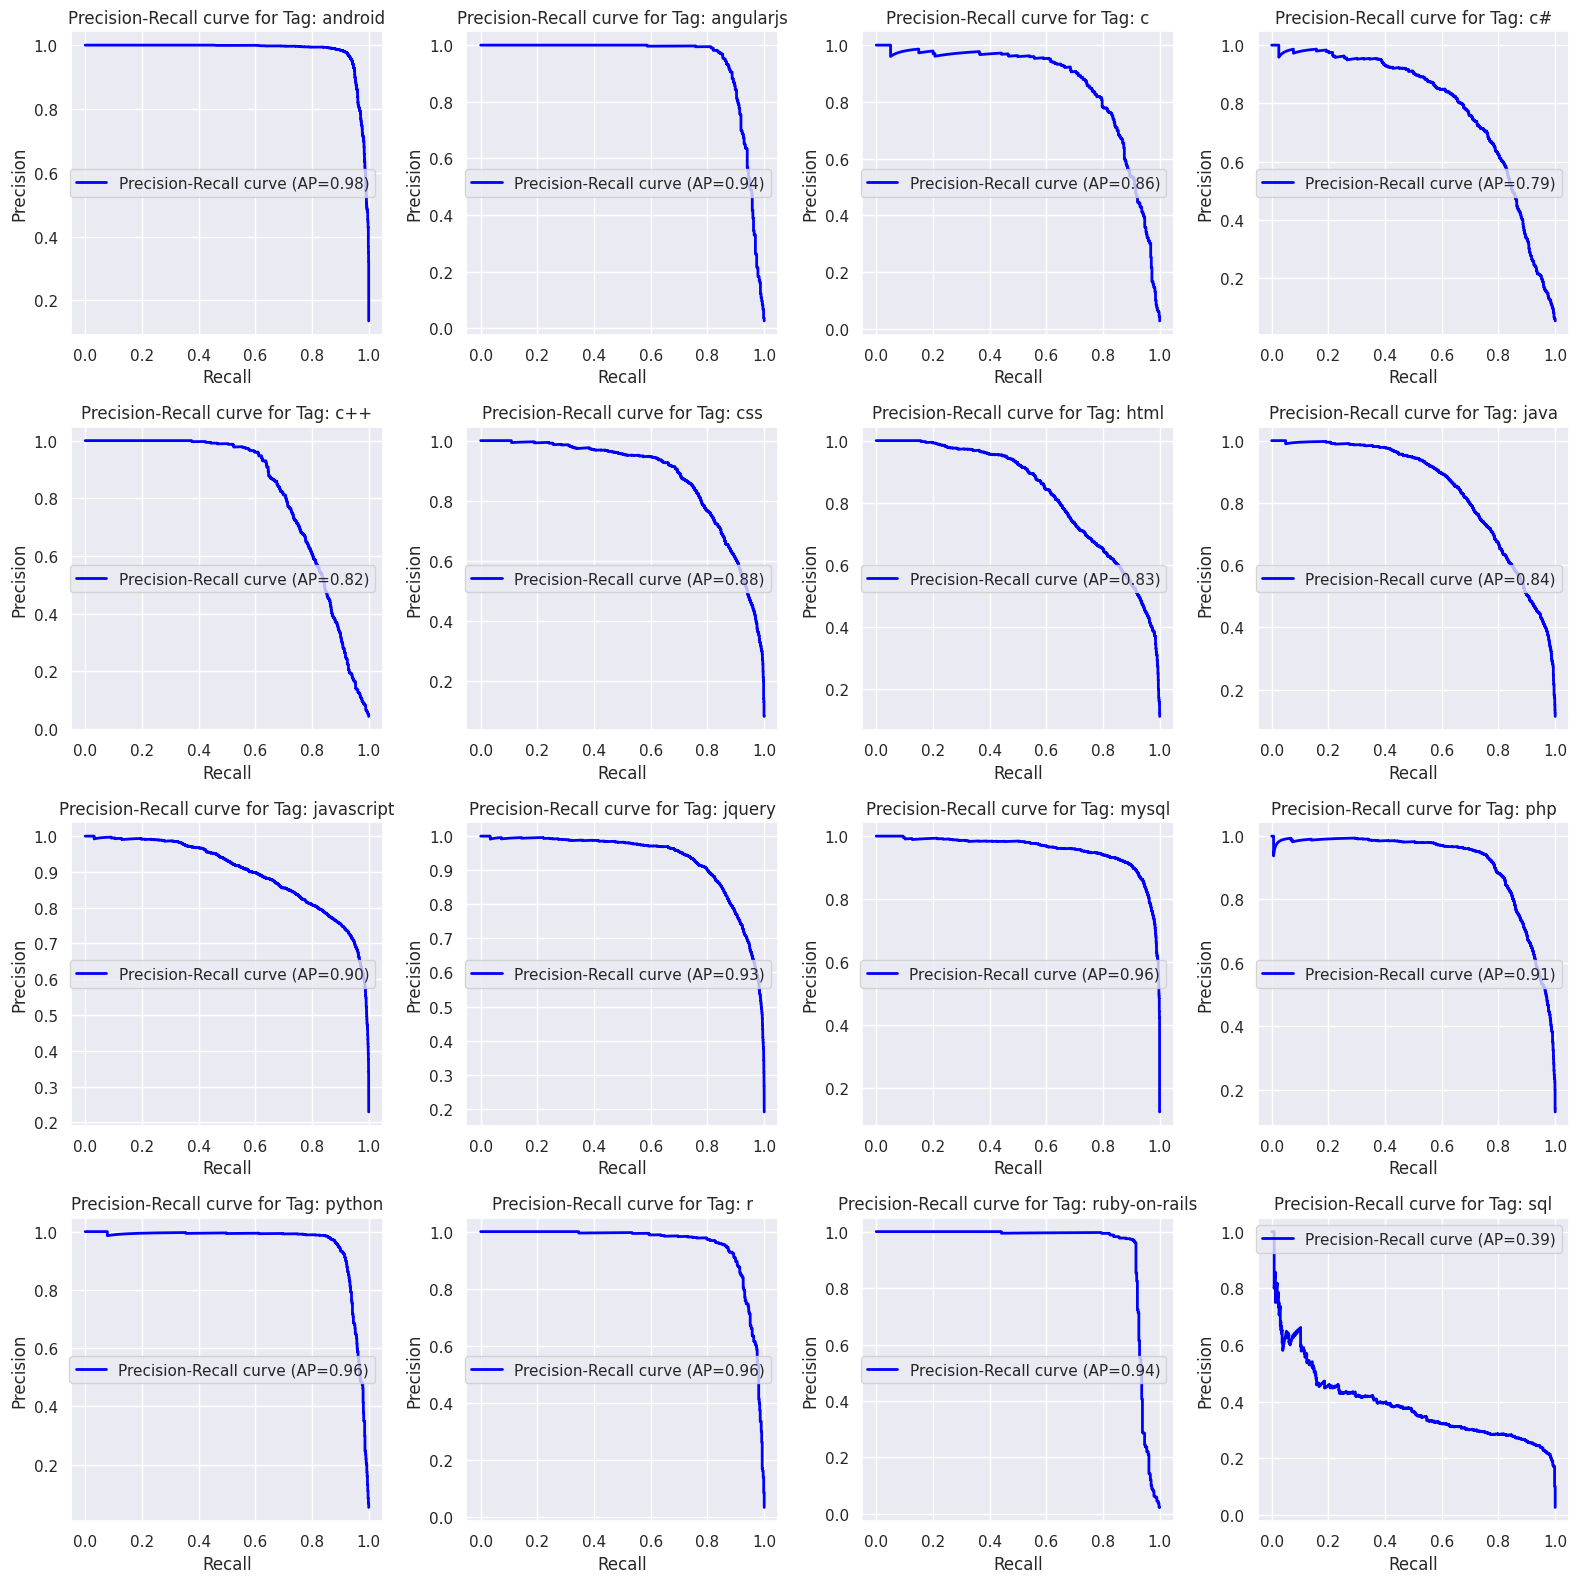

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_true =y_test # actual label
y_pred = best_model.predict(sequence_test_padded) # Predicted labels

# Number of tags (e.g., if there are 16 tags, this will work for a 4x4 grid)
num_tags = y_true.shape[1]

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten() # Flatten the 2D axes array to make indexing easier

# Loop over all tags and plot Precision-Recall curve for each
for i in range(num_tags):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision = average_precision_score(y_true[:, i], y_pred[:, i])

    ax = axes[i]
    ax.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP={average_precision:.2f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall curve for Tag: {mlb.classes_[i]}')
    ax.legend(loc='best')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


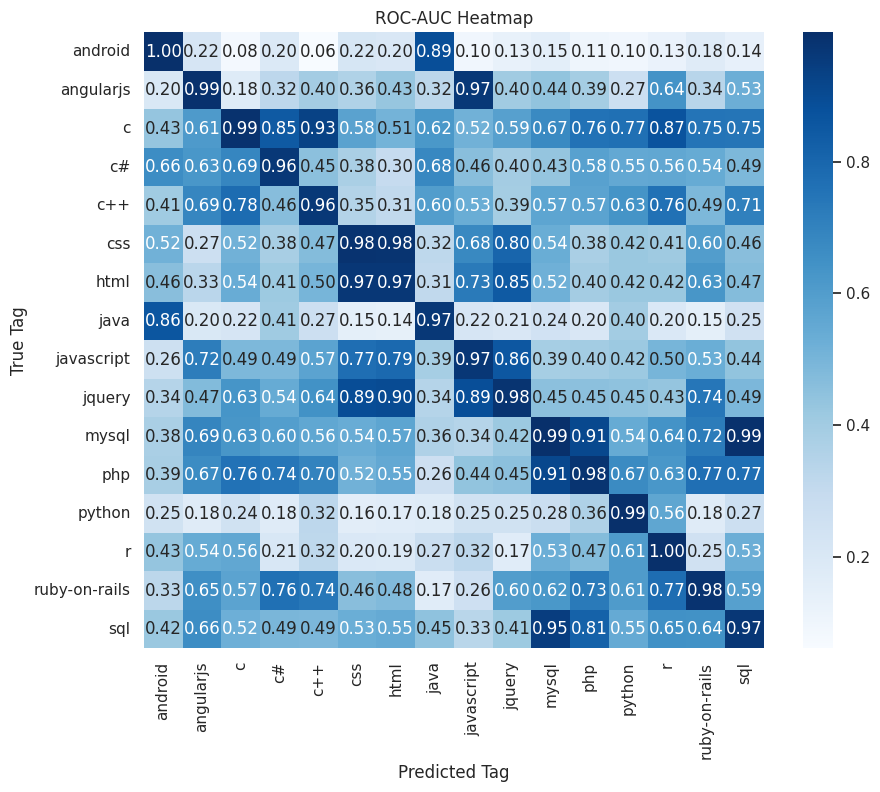

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

# y_true and y_pred are true and predicted labels

# Compute ROC-AUC for each tag (column-wise)
roc_auc_matrix = np.zeros((y_true.shape[1], y_true.shape[1]))
for i in range(y_true.shape[1]):
    for j in range(y_true.shape[1]):
        roc_auc_matrix[i, j] = roc_auc_score(y_true[:, i], y_pred[:, j])

# Plotting the ROC-AUC heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(roc_auc_matrix, annot=True, cmap='Blues', fmt='.2f',
            xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title('ROC-AUC Heatmap')
plt.xlabel('Predicted Tag')
plt.ylabel('True Tag')
plt.show()


GRU has performed bettet than RNN and LSTM for this dataset